<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Tutorials/Generative/Deep%20Dream/Deep_Dream_with_Tiles_and_Octaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%time
from __future__ import absolute_import, print_function, unicode_literals, division

%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.
CPU times: user 1.22 s, sys: 310 ms, total: 1.53 s
Wall time: 2.93 s


In [0]:
import os
import scipy
from PIL import Image
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import get_file, plot_model

In [0]:
URL = 'https://image.businessinsider.com/5dd2cbcf7eece54f172baab4?width=1100&format=jpeg&auto=webp'

49152/47642 [==============================] - 0s 0us/step


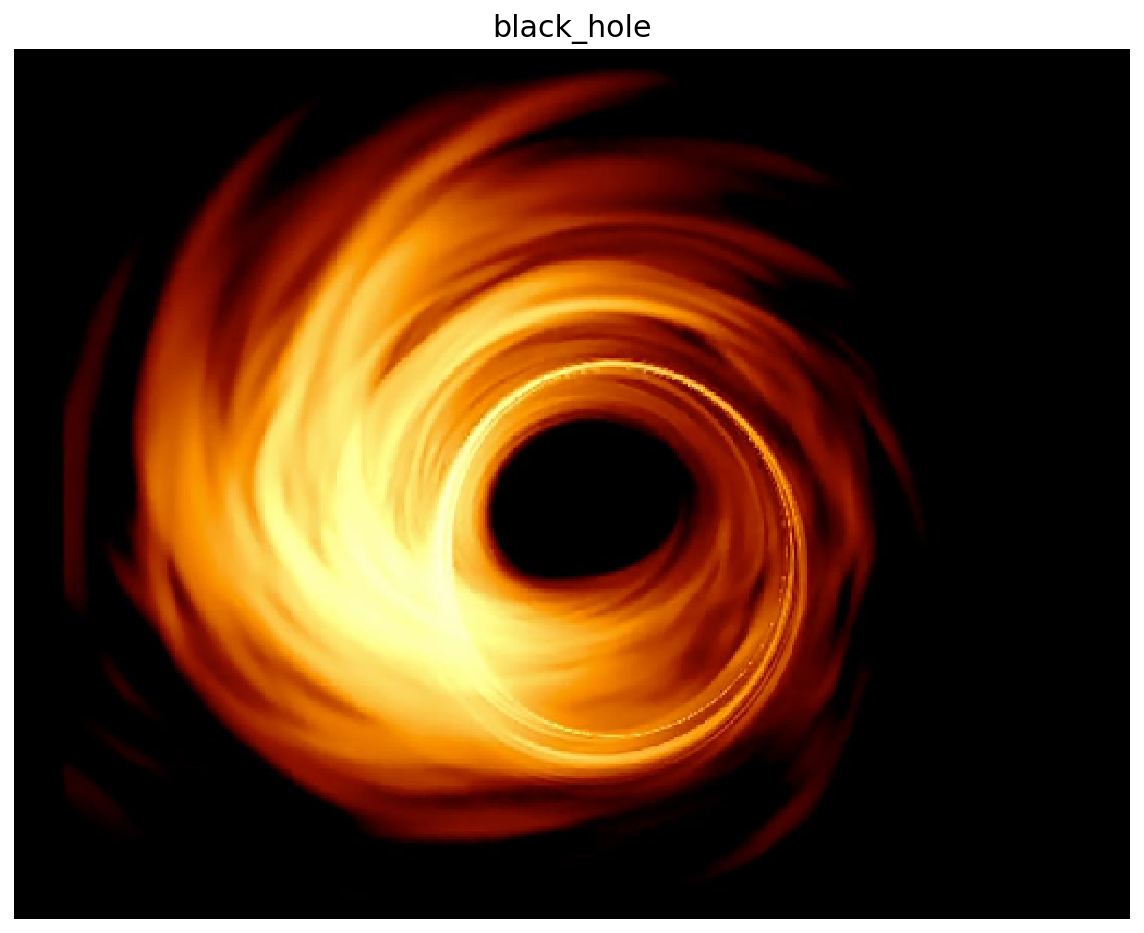

In [0]:
# Download an image
def download(url, target_size=None):
  # name = url.split('/')[-1]
  name = 'galaxy.jpg'
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

# Normalize an image
def deprocess(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img, title=None):
  if len(img.shape)>3:
    img = np.squeeze(img)
  plt.figure(figsize=(10,8))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img, interpolation='nearest', aspect="auto")
  if title:
    plt.title(title, fontsize=15)
  plt.show()

original_image = download(URL, target_size=[512,512])
original_image = np.array(original_image)
show(original_image, title="black_hole")

In [0]:
%%time
base_model = InceptionV3(include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 3s 0us/step
CPU times: user 4.79 s, sys: 649 ms, total: 5.44 s
Wall time: 11 s


In [0]:
for layer in base_model.layers:
  if "mixed" in layer.name:
    print(layer.name)

mixed0
mixed1
mixed2
mixed3
mixed4
mixed5
mixed6
mixed7
mixed8
mixed9_0
mixed9
mixed9_1
mixed10


In [0]:
#names = ['mixed3','mixed5', 'mixed7']
#names = ['mixed3', 'mixed4', 'mixed6', 'mixed7']
names = ['mixed5','mixed6', 'mixed8', 'mixed9_0']
layers = [base_model.get_layer(name).output for name in names]
deep_dream = Model(base_model.input, layers)

In [0]:
layers

[<tf.Tensor 'mixed5/Identity:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed6/Identity:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed8/Identity:0' shape=(None, None, None, 1280) dtype=float32>,
 <tf.Tensor 'mixed9_0/Identity:0' shape=(None, None, None, 768) dtype=float32>]

In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_sum(act)
    losses.append(loss)
  return tf.reduce_sum(losses)

In [0]:
@tf.function
def deepdream(model, img, step_size):
  with tf.GradientTape(watch_accessed_variables=True) as tape:
    # This needs gradients relative to `img`
    # `GradientTape` only watches `tf.Variable`s by default
    tape.watch(img)
    loss = calc_loss(img, model)
  # Calculate the gradient of the loss with respect to the pixels of the input image.
  gradients = tape.gradient(loss, img)

  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  # gradient ascent
  img = img + gradients * step_size

  img = tf.clip_by_value(img, clip_value_max=1.0, clip_value_min=-1.0)

  return loss, img

In [0]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  for step in range(steps):
    loss, img = deepdream(model, img, step_size)
    print(step, end=" ")
    if step % 100 == 0:
      clear_output(wait=True)
      show(deprocess(img))
      print(f"Step {step}, Loss {loss}")
  result = deprocess(img)
  clear_output(wait = True)
  show(result)

  return result

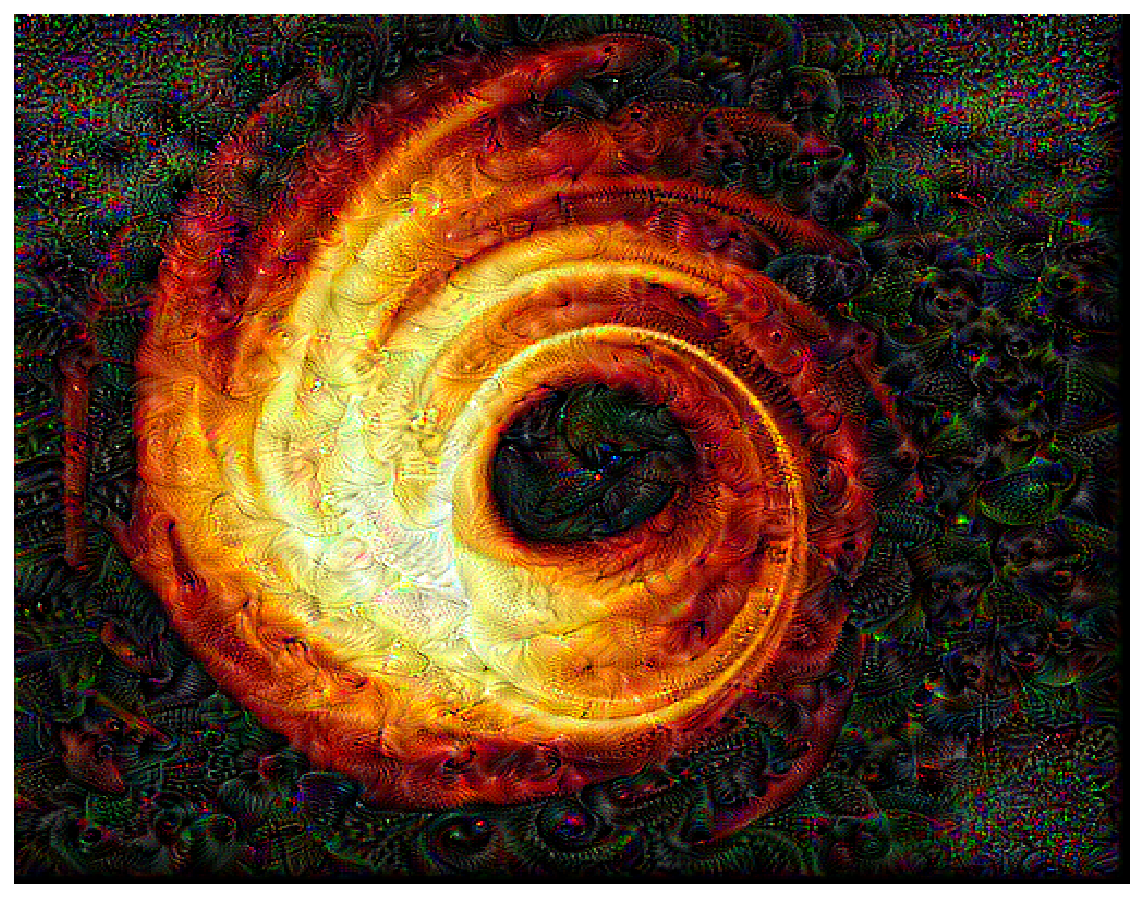

CPU times: user 15.8 s, sys: 3.5 s, total: 19.3 s
Wall time: 19.5 s


In [0]:
%%time
dream_img = run_deep_dream_simple(deep_dream, original_image, 400, 0.01)

### Taking it up by an Octave

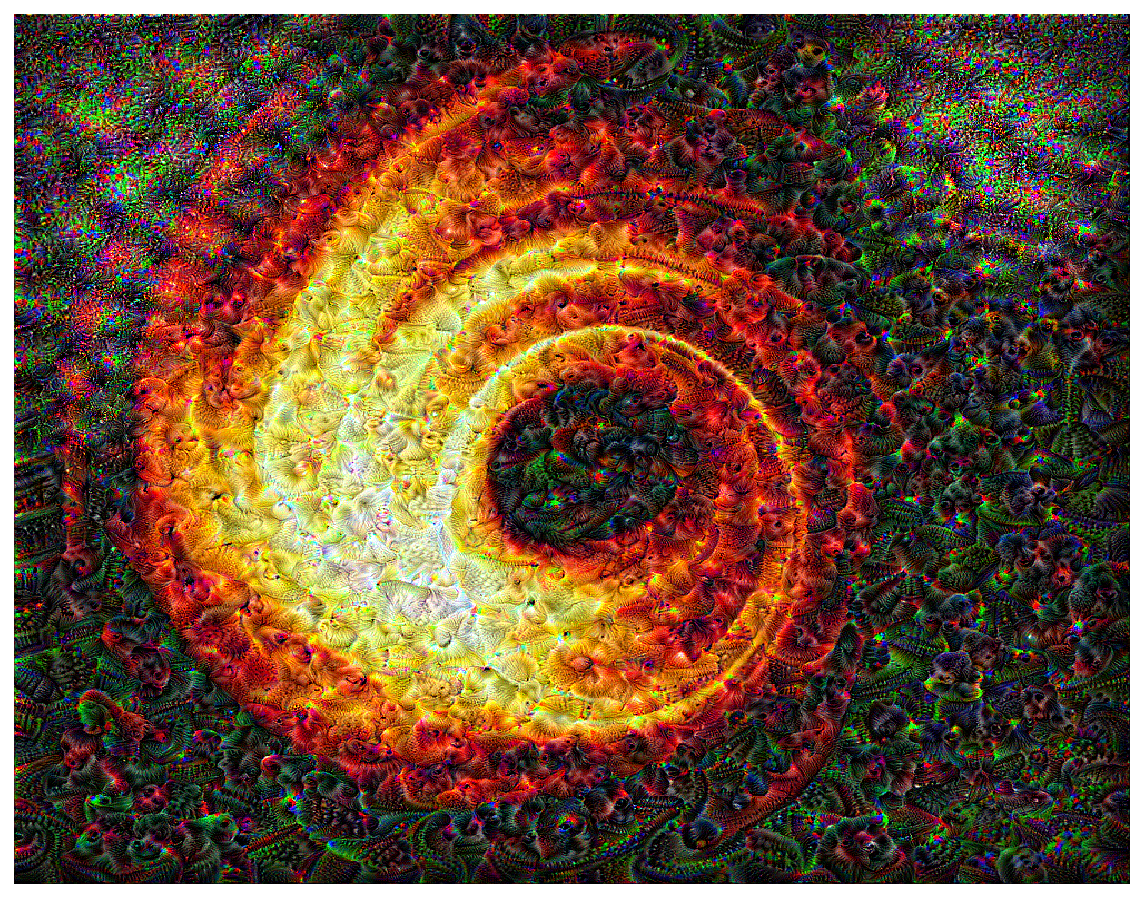

In [0]:
OCTAVE_SCALE = 1.4
img = tf.constant(np.array(original_image))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
for n in range(3):
  new_shape = tf.cast(base_shape * (OCTAVE_SCALE ** n), tf.int32)
  img = tf.image.resize(img, new_shape).numpy()
  img = run_deep_dream_simple(model=deep_dream, img = img, steps=300, step_size=0.01)

### Scaling up with Tiles

In [0]:
def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval = -maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0], shift[1]
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

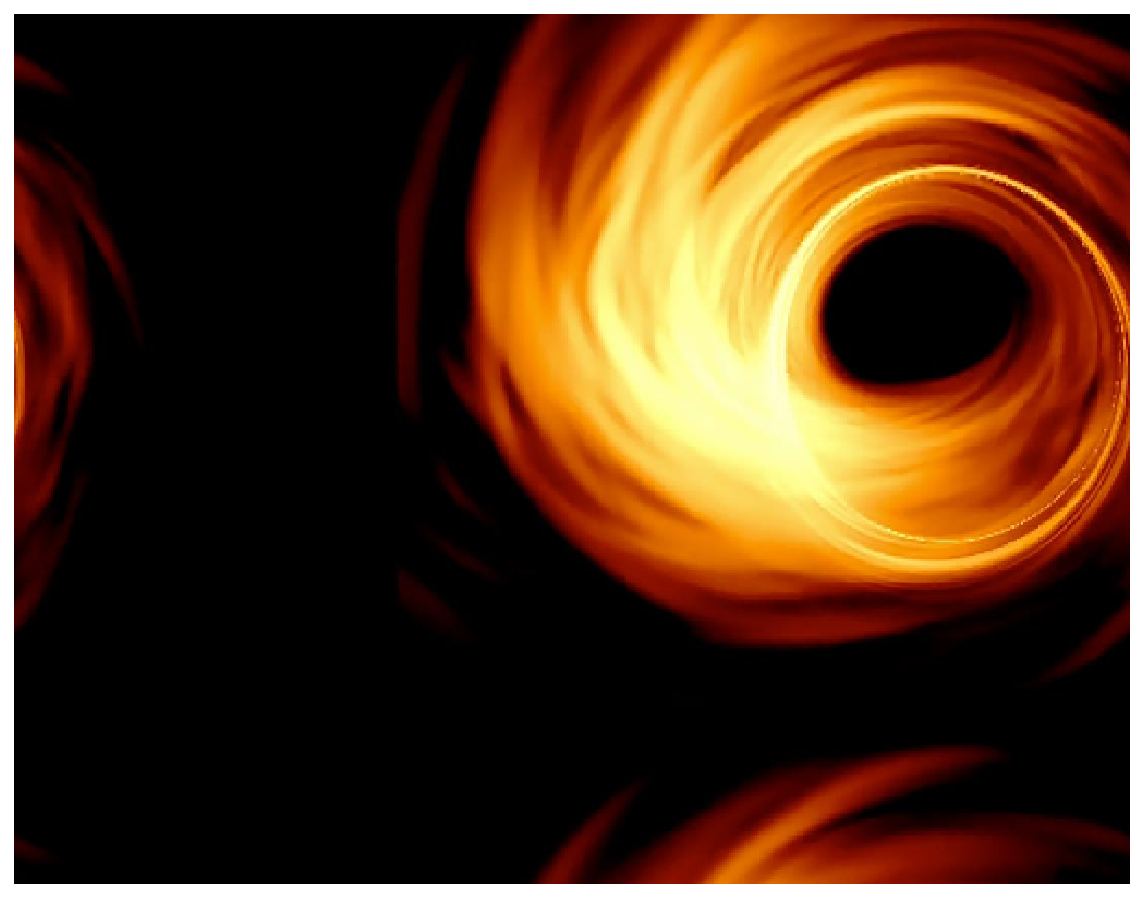

In [0]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_image), 512)
show(img_rolled)

In [0]:
@tf.function
def get_tiled_gradients(model, img, tile_size=512):
  shift_down, shift_right, img_rolled = random_roll(img, tile_size)
  gradients = tf.zeros_like(img_rolled)
  for x in tf.range(0, img_rolled.shape[0], tile_size):
    for y in tf.range(0, img_rolled.shape[1], tile_size):
      with tf.GradientTape(watch_accessed_variables=True) as tape:
        tape.watch(img_rolled)
        img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(img_tile, model)
      gradients = gradients + tape.gradient(loss, img_rolled)
  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
  gradients /= tf.math.reduce_std(gradients) + 1e-8
  return gradients

In [0]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  for octave in range(num_octaves):
    if octave>0:
      new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
      img = tf.image.resize(img, tf.cast(new_size, tf.int32))
    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(model, img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)
      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
  clear_output(wait=True)
  result = deprocess(img)
  show(result)
  return result

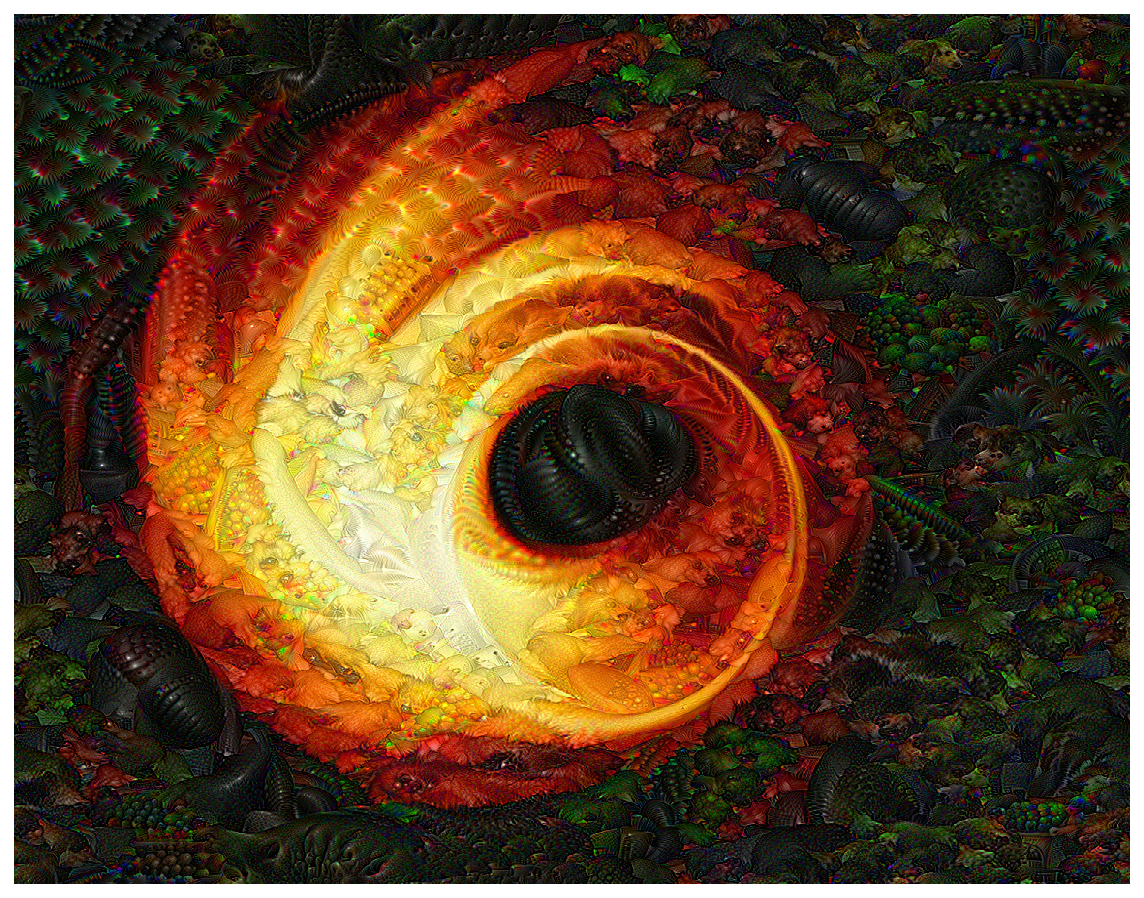

In [0]:
dream_img = run_deep_dream_with_octaves(deep_dream, original_image, steps_per_octave=200, step_size=0.01, num_octaves=3, octave_scale=1.5)

In [0]:
image.save_img('deep_dream_black_hole.png', dream_img)